In [18]:
# Importation des bibliothèques nécessaires
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Bibliothèques importées avec succès!")
print(f"Date d'analyse : {datetime.now().strftime('%Y-%m-%d')}")

Bibliothèques importées avec succès!
Date d'analyse : 2025-11-14


In [19]:
# Définition des tickers Yahoo Finance pour les indices
tickers = {
    'S&P 500': '^GSPC',       # Référence américaine
    'DAX 40': '^GDAXI',       # Allemagne (marché développé)
    'Nikkei 225': '^N225',    # Japon (marché développé)
    'Bovespa': '^BVSP',       # Brésil (marché émergent)
    'Nifty 50': '^NSEI',      # Inde (marché émergent)
    'HSI': '^HSI'             # Hong Kong/Chine (marché asiatique)
}

# Période d'analyse : 2010 à aujourd'hui
start_date = '2010-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

print("Tickers définis :")
for nom, ticker in tickers.items():
    print(f"  {nom}: {ticker}")
print(f"\nPériode d'analyse : {start_date} à {end_date}")

Tickers définis :
  S&P 500: ^GSPC
  DAX 40: ^GDAXI
  Nikkei 225: ^N225
  Bovespa: ^BVSP
  Nifty 50: ^NSEI
  HSI: ^HSI

Période d'analyse : 2010-01-01 à 2025-11-14


In [20]:
# Téléchargement des données de prix des indices
print("Téléchargement des données en cours...")

# Créer un DataFrame pour stocker les prix de clôture ajustés
price_data = pd.DataFrame()

for nom, ticker in tickers.items():
    try:
        print(f"  Téléchargement de {nom} ({ticker})...")
        data = yf.download(ticker, start=start_date, end=end_date, progress=False)
        
        if not data.empty and 'Adj Close' in data.columns:
            # Utiliser les prix de clôture ajustés
            price_data[nom] = data['Adj Close']
            print(f"    ✓ {len(data)} observations récupérées")
        elif not data.empty:
            # Si pas d'Adj Close, utiliser Close
            price_data[nom] = data['Close']
            print(f"    ✓ {len(data)} observations récupérées (Close utilisé)")
        else:
            print(f"    ✗ Aucune donnée récupérée pour {nom}")
            
    except Exception as e:
        print(f"    ✗ Erreur lors du téléchargement de {nom}: {e}")

print(f"\nTéléchargement terminé!")

if not price_data.empty:
    print(f"Période effective : {price_data.index[0].strftime('%Y-%m-%d')} à {price_data.index[-1].strftime('%Y-%m-%d')}")
    print(f"Nombre total d'observations : {len(price_data)}")
    print(f"Indices récupérés : {list(price_data.columns)}")
    
    # Afficher les premières lignes
    print(f"\nPremières observations :")
    print(price_data.head())
else:
    print("Aucune donnée n'a pu être récupérée.")
    
# Vérifier s'il y a des valeurs manquantes
if not price_data.empty:
    print(f"\nValeurs manquantes par indice :")
    print(price_data.isnull().sum())

Téléchargement des données en cours...
  Téléchargement de S&P 500 (^GSPC)...
    ✓ 3992 observations récupérées (Close utilisé)
  Téléchargement de DAX 40 (^GDAXI)...
    ✓ 4029 observations récupérées (Close utilisé)
  Téléchargement de Nikkei 225 (^N225)...
    ✓ 3881 observations récupérées (Close utilisé)
  Téléchargement de Bovespa (^BVSP)...
    ✓ 3935 observations récupérées (Close utilisé)
  Téléchargement de Nifty 50 (^NSEI)...
    ✓ 3896 observations récupérées (Close utilisé)
  Téléchargement de HSI (^HSI)...
    ✓ 3906 observations récupérées (Close utilisé)

Téléchargement terminé!
Période effective : 2010-01-04 à 2025-11-13
Nombre total d'observations : 3992
Indices récupérés : ['S&P 500', 'DAX 40', 'Nikkei 225', 'Bovespa', 'Nifty 50', 'HSI']

Premières observations :
                S&P 500       DAX 40    Nikkei 225  Bovespa     Nifty 50  \
Date                                                                       
2010-01-04  1132.989990  6048.299805  10654.790039  70

In [21]:
# Préparation des données explicatives pour chaque marché (fusion VIX + alignement régression) pour 2.3
print("Téléchargement et préparation des données VIX pour la régression explicative...")

# Télécharger les données VIX
vix_data = yf.download('^VIX', start=start_date, end=end_date, progress=False)

# Robust: s'assurer que 'correlations' existe et a un index temporel pertinent
if 'correlations' not in globals() or not isinstance(globals().get('correlations'), pd.DataFrame):
    if 'price_data_clean' in globals() and isinstance(price_data_clean, pd.DataFrame) and isinstance(price_data_clean.index, pd.DatetimeIndex):
        correlations = pd.DataFrame(index=price_data_clean.index)
    elif 'price_data' in globals() and isinstance(price_data, pd.DataFrame) and isinstance(price_data.index, pd.DatetimeIndex):
        correlations = pd.DataFrame(index=price_data.index)
    else:
        correlations = pd.DataFrame()

if not vix_data.empty:
    # Si correlations n'a pas d'index temporel ou est vide, aligner sur l'index VIX
    # (on crée l'index avant de réindexer pour éviter NameError ou index non-datetime)
    if correlations.empty or not isinstance(correlations.index, pd.DatetimeIndex) or len(correlations.index) == 0:
        # extraire un index temporel depuis vix_data (sûr)
        correlations = pd.DataFrame(index=vix_data.index)

    # Extraire la série "Close" de vix_data en gérant multi-index ou colonnes simples
    if 'Close' in vix_data.columns:
        vix_close = vix_data['Close']
    elif isinstance(vix_data.columns, pd.MultiIndex):
        if ('Close', '^VIX') in vix_data.columns:
            vix_close = vix_data[('Close', '^VIX')]
        else:
            close_cols = [c for c in vix_data.columns if c[0] == 'Close']
            if close_cols:
                vix_close = vix_data[close_cols[0]]
            else:
                vix_close = vix_data.iloc[:, 0]
    else:
        vix_close = vix_data.iloc[:, 0]

    # Si vix_close est DataFrame à une colonne, convertir en Series
    if isinstance(vix_close, pd.DataFrame) and vix_close.shape[1] == 1:
        vix_close = vix_close.iloc[:, 0]

    # Aligner et calculer log(VIX)
    vix_aligned = vix_close.reindex(correlations.index, method='ffill')
    vix_aligned = vix_aligned.astype(float)
    log_vix = np.log(vix_aligned)

    print(f"✓ Données VIX récupérées : {vix_aligned.shape[0]} observations")
    print(f"Période VIX alignée : {vix_aligned.index[0].strftime('%Y-%m-%d')} à {vix_aligned.index[-1].strftime('%Y-%m-%d')}")

    # Statistiques descriptives du VIX et log(VIX)
    print("\nStatistiques descriptives du VIX :")
    print(f"VIX - Moyenne: {float(vix_aligned.mean()):.2f}, Écart-type: {float(vix_aligned.std()):.2f}")
    print(f"VIX - Min: {float(vix_aligned.min()):.2f}, Max: {float(vix_aligned.max()):.2f}")

    print("\nStatistiques descriptives de log(VIX) :")
    print(f"log(VIX) - Moyenne: {float(log_vix.mean()):.4f}, Écart-type: {float(log_vix.std()):.4f}")
    print(f"log(VIX) - Min: {float(log_vix.min()):.4f}, Max: {float(log_vix.max()):.4f}")

    # Sauvegarder pour les étapes suivantes (s'assurer que l'on colle des Series)
    correlations['VIX'] = vix_aligned
    correlations['log_VIX'] = log_vix

    print("\n✓ Variables ajoutées au DataFrame des corrélations")
    print(f"Shape final du DataFrame : {correlations.shape}")

    # Vérifier la cohérence des données
    print("\nVérification des données finales :")
    print("Valeurs manquantes :")
    print(correlations[['VIX', 'log_VIX']].isnull().sum())

    # Préparation des données pour la régression explicative (Corr vs log(VIX))
    print("\nPréparation des données pour la régression explicative (Corr vs log(VIX))...")
    markets = [col for col in correlations.columns if col.startswith('Corr_')]
    regression_data = {}
    for market in markets:
        # Extraire la série de corrélation et log(VIX), aligner et retirer les valeurs nulles
        df = pd.DataFrame({
            'Corr': correlations[market],
            'log_VIX': correlations['log_VIX']
        }).dropna()
        regression_data[market] = df
        print(f"{market}: {len(df)} observations alignées, période {df.index[0].strftime('%Y-%m-%d')} à {df.index[-1].strftime('%Y-%m-%d')}")

    # Vérification rapide
    for market, df in regression_data.items():
        print(f"\n{market} - Aperçu des données alignées :")
        print(df.head())

else:
    print("✗ Erreur lors du téléchargement des données VIX")

Téléchargement et préparation des données VIX pour la régression explicative...
✓ Données VIX récupérées : 3062 observations
Période VIX alignée : 2010-08-09 à 2025-07-07

Statistiques descriptives du VIX :
VIX - Moyenne: 18.21, Écart-type: 6.93
VIX - Min: 9.22, Max: 82.69

Statistiques descriptives de log(VIX) :
log(VIX) - Moyenne: 2.8468, Écart-type: 0.3177
log(VIX) - Min: 2.2214, Max: 4.4151

✓ Variables ajoutées au DataFrame des corrélations
Shape final du DataFrame : (3062, 9)

Vérification des données finales :
Valeurs manquantes :
VIX        0
log_VIX    0
dtype: int64

Préparation des données pour la régression explicative (Corr vs log(VIX))...
Corr_DAX 40: 3062 observations alignées, période 2010-08-09 à 2025-07-07
Corr_Nikkei 225: 3062 observations alignées, période 2010-08-09 à 2025-07-07
Corr_Bovespa: 3062 observations alignées, période 2010-08-09 à 2025-07-07
Corr_Nifty 50: 3062 observations alignées, période 2010-08-09 à 2025-07-07
Corr_HSI: 3062 observations alignées, pé

In [22]:
# Nettoyage des données et calcul des rendements
print("Nettoyage des données et calcul des rendements...")

# Supprimer les lignes avec des valeurs manquantes (utilisation des dates communes)
price_data_clean = price_data.dropna()

print(f"Après nettoyage : {len(price_data_clean)} observations communes")
print(f"Période effective après nettoyage : {price_data_clean.index[0].strftime('%Y-%m-%d')} à {price_data_clean.index[-1].strftime('%Y-%m-%d')}")

# Calcul des rendements logarithmiques
returns = np.log(price_data_clean / price_data_clean.shift(1)).dropna()

print(f"Nombre d'observations de rendements : {len(returns)}")
print(f"\nStatistiques descriptives des rendements (%):")
print((returns * 100).describe().round(4))

Nettoyage des données et calcul des rendements...
Après nettoyage : 3266 observations communes
Période effective après nettoyage : 2010-01-04 à 2025-11-13
Nombre d'observations de rendements : 3265

Statistiques descriptives des rendements (%):
         S&P 500     DAX 40  Nikkei 225    Bovespa   Nifty 50        HSI
count  3265.0000  3265.0000   3265.0000  3265.0000  3265.0000  3265.0000
mean      0.0546     0.0423      0.0481     0.0248     0.0490     0.0066
std       1.1844     1.3504      1.4658     1.5887     1.1282     1.4469
min     -12.7652   -13.0549    -13.2341   -15.9930    -8.6669   -14.1833
25%      -0.4113    -0.5431     -0.6750    -0.8160    -0.5053    -0.7432
50%       0.0827     0.0848      0.0734     0.0274     0.0768     0.0322
75%       0.6091     0.7128      0.8234     0.8874     0.6645     0.7749
max       9.0895    10.4143      9.7366    13.0223     8.4003     8.6928


In [23]:
# Calcul des corrélations mobiles sur 126 jours (6 mois)
print("Calcul des corrélations mobiles sur 126 jours...")

window = 126  # 6 mois de données quotidiennes
correlations = pd.DataFrame(index=returns.index)

# Indices internationaux (excluant S&P 500)
international_indices = [col for col in returns.columns if col != 'S&P 500']

# Calcul des corrélations mobiles avec le S&P 500
for indice in international_indices:
    correlation_series = returns['S&P 500'].rolling(window=window).corr(returns[indice])
    correlations[f'Corr_{indice}'] = correlation_series

# Supprimer les valeurs NaN dues à la fenêtre mobile
correlations = correlations.dropna()

# Limiter la période de corrélation entre 126 jours après le 2010-01-01 et 126 jours avant le 2025-11-10
date_debut_corr = pd.to_datetime('2010-01-01') + pd.Timedelta(days=126)
date_fin_corr = pd.to_datetime('2025-11-10') - pd.Timedelta(days=126)
correlations = correlations[(correlations.index >= date_debut_corr) & (correlations.index <= date_fin_corr)]

print(f"Nombre d'observations de corrélations : {len(correlations)}")
print(f"Période des corrélations : {correlations.index[0].strftime('%Y-%m-%d')} à {correlations.index[-1].strftime('%Y-%m-%d')}")

print(f"\nStatistiques descriptives des corrélations mobiles :")
print(correlations.describe().round(4))

# === Ajout direct du VIX et log(VIX) dans correlations ===
import yfinance as yf
import numpy as np

try:
    vix_data = yf.download('^VIX', start=correlations.index[0].strftime('%Y-%m-%d'), end=correlations.index[-1].strftime('%Y-%m-%d'), progress=False)
    if not vix_data.empty and 'Close' in vix_data.columns:
        vix_aligned = vix_data['Close'].reindex(correlations.index, method='ffill')
        log_vix = np.log(vix_aligned)
        correlations['log_VIX'] = log_vix

        logvix_stats = correlations['log_VIX'].describe(percentiles=[0.25, 0.5, 0.75]).to_dict()

        def format_stats(stats, label):
            return {
                'Série': label,
                'Moyenne': f"{stats['mean']:.4f}",
                'Écart-type': f"{stats['std']:.4f}",
                'Minimum': f"{stats['min']:.4f}",
                'Q1': f"{stats['25%']:.4f}",
                'Médiane': f"{stats['50%']:.4f}",
                'Q3': f"{stats['75%']:.4f}",
                'Maximum': f"{stats['max']:.4f}",
                'N obs.': int(stats['count'])
            }

        stats_table = [
            format_stats(logvix_stats, 'log(VIX)')
        ]

        import pandas as pd
        df_logvix_stats = pd.DataFrame(stats_table)
        print("\n STATISTIQUES DESCRIPTIVES PROFESSIONNELLES - log(VIX)")
        print("="*80)
        print(df_logvix_stats.to_string(index=False))
        print("="*80)
    else:
        print("\n(log(VIX) non disponible : téléchargement VIX échoué ou colonne 'Close' absente)")
except Exception as e:
    print(f"\nErreur lors du téléchargement ou du traitement du VIX : {e}")

Calcul des corrélations mobiles sur 126 jours...
Nombre d'observations de corrélations : 3062
Période des corrélations : 2010-08-09 à 2025-07-07

Statistiques descriptives des corrélations mobiles :
       Corr_DAX 40  Corr_Nikkei 225  Corr_Bovespa  Corr_Nifty 50   Corr_HSI
count    3062.0000        3062.0000     3062.0000      3062.0000  3062.0000
mean        0.5766           0.2456        0.4983         0.2747     0.2417
std         0.1172           0.1032        0.1903         0.1350     0.1358
min         0.2788          -0.0286       -0.0053        -0.0119    -0.0907
25%         0.5069           0.1754        0.3674         0.1685     0.1300
50%         0.5643           0.2461        0.4960         0.2626     0.2683
75%         0.6569           0.3164        0.6198         0.3811     0.3421
max         0.8463           0.6090        0.9156         0.6433     0.4921

 STATISTIQUES DESCRIPTIVES PROFESSIONNELLES - log(VIX)
   Série Moyenne Écart-type Minimum     Q1 Médiane     Q3 Max

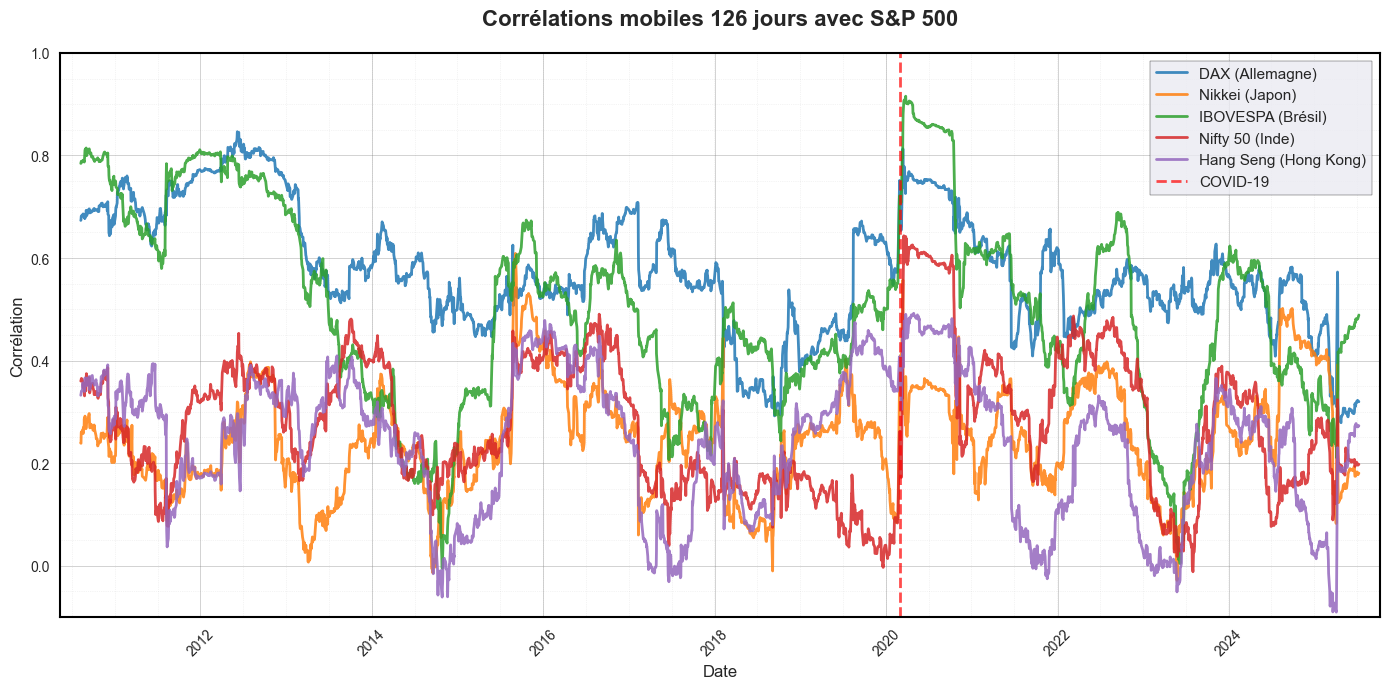


 CORRÉLATIONS MOYENNES PAR TYPE DE MARCHÉ :
Marchés développés :
  • DAX 40 (Allemagne) : 0.5766
  • Nikkei 225 (Japon) : 0.2456

Marchés émergents :
  • Bovespa (Brésil) : 0.4983
  • Nifty 50 (Inde) : 0.2747

Marché asiatique :
  • HSI (Hong Kong) : 0.2417


In [24]:
# Visualisation des corrélations mobiles - Graphique unique consolidé
plt.figure(figsize=(14, 7))

# Couleurs distinctes pour chaque indice
colors = {
    'Corr_DAX 40': '#1f77b4',      # Bleu - DAX (Allemagne)
    'Corr_Nikkei 225': '#ff7f0e',  # Orange - Nikkei (Japon)
    'Corr_Bovespa': '#2ca02c',     # Vert - IBOVESPA (Brésil)
    'Corr_Nifty 50': '#d62728',    # Rouge - Nifty 50 (Inde)
    'Corr_HSI': '#9467bd'          # Violet - Hang Seng (Hong Kong)
}

# Noms complets pour la légende
legend_names = {
    'Corr_DAX 40': 'DAX (Allemagne)',
    'Corr_Nikkei 225': 'Nikkei (Japon)',
    'Corr_Bovespa': 'IBOVESPA (Brésil)',
    'Corr_Nifty 50': 'Nifty 50 (Inde)',
    'Corr_HSI': 'Hang Seng (Hong Kong)'
}

# Tracer toutes les corrélations sur le même graphique (uniquement les colonnes principales)
for col in ['Corr_DAX 40', 'Corr_Nikkei 225', 'Corr_Bovespa', 'Corr_Nifty 50', 'Corr_HSI']:
    if col in correlations.columns:
        y = correlations[col]
        valid_idx = ~y.isna()
        x_valid = correlations.index[valid_idx]
        y_valid = y[valid_idx]
        plt.plot(x_valid, y_valid, color=colors[col], linewidth=2, alpha=0.85, label=legend_names[col])

# Configuration du graphique
plt.title('Corrélations mobiles 126 jours avec S&P 500', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Corrélation', fontsize=12)
# Quadrillage bien visible (gris clair, lignes pleines et pointillées)
plt.grid(True, which='major', axis='both', color='gray', linestyle='-', linewidth=0.7, alpha=0.35)
plt.minorticks_on()
plt.grid(True, which='minor', axis='both', color='gray', linestyle=':', linewidth=0.5, alpha=0.18)
plt.gca().set_facecolor('white')

# Ajouter les événements majeurs
plt.axvline(pd.to_datetime('2020-03-01'), color='red', linestyle='--', alpha=0.7, linewidth=2, label='COVID-19')
# plt.axvline(pd.to_datetime('2022-02-01'), color='orange', linestyle='--', alpha=0.7, linewidth=2, label='Inflation 2022')  # Ligne inflation retirée

# Rectangle bien tracé autour du graphique
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

# Lignes pleines pour les axes X et Y
ax.spines['left'].set_linestyle('-')
ax.spines['bottom'].set_linestyle('-')

# Configuration de la légende (en haut à droite, dans le graphique, rectangle visible)
plt.legend(loc='upper right', frameon=True, fancybox=False, shadow=False, fontsize=11, edgecolor='black')

# Ajustement des limites et formatage (moins zoomé)
plt.ylim(-0.1, 1.0)
plt.xlim(correlations.index[0] - pd.Timedelta(days=90), correlations.index[-1] + pd.Timedelta(days=90))

# Format des dates sur l'axe x
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Afficher les corrélations moyennes par type de marché
print("\n CORRÉLATIONS MOYENNES PAR TYPE DE MARCHÉ :")
print("=" * 60)
print("Marchés développés :")
print(f"  • DAX 40 (Allemagne) : {correlations['Corr_DAX 40'].mean():.4f}")
print(f"  • Nikkei 225 (Japon) : {correlations['Corr_Nikkei 225'].mean():.4f}")
print("\nMarchés émergents :")
print(f"  • Bovespa (Brésil) : {correlations['Corr_Bovespa'].mean():.4f}")
print(f"  • Nifty 50 (Inde) : {correlations['Corr_Nifty 50'].mean():.4f}")
print("\nMarché asiatique :")
print(f"  • HSI (Hong Kong) : {correlations['Corr_HSI'].mean():.4f}")


In [25]:
# TESTS DE STATIONNARITÉ - PP et KPSS uniquement
from statsmodels.tsa.stattools import kpss
from arch.unitroot import PhillipsPerron
from statsmodels.tools.sm_exceptions import InterpolationWarning
import warnings

print(" TESTS DE STATIONNARITÉ DES CORRÉLATIONS MOBILES (PP et KPSS)")
print("=" * 60)

def test_stationarity_pp_kpss(series, name):
    # Test Phillips-Perron
    pp_test = PhillipsPerron(series)
    pp_stat, pp_pval = pp_test.stat, pp_test.pvalue
    pp_stationary = pp_pval < 0.05  # Rejet H0: stationnaire

    # Test KPSS
    # Certains cas déclenchent une InterpolationWarning dans statsmodels (statistique hors table)
    # Nous capturons et ignorons uniquement cette catégorie de warning pour garder la sortie propre.
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=InterpolationWarning)
        kpss_result = kpss(series, regression='c', nlags='auto')

    kpss_stat, kpss_pval = kpss_result[0], kpss_result[1]
    kpss_stationary = kpss_pval >= 0.05  # Non-rejet H0: stationnaire

    # Interprétation croisée corrigée
    if pp_stationary and kpss_stationary:
        conclusion = "Stationnaire (tests cohérents)"
    elif pp_stationary and not kpss_stationary:
        conclusion = "Tests contradictoires (PP: stationnaire, KPSS: non-stationnaire)"
    elif not pp_stationary and kpss_stationary:
        conclusion = "Non-stationnaire (tests cohérents)"
    else:
        conclusion = "Non-stationnaire (tests cohérents)"

    return {
        'nom': name,
        'PP Stat': pp_stat,
        'PP p-val': pp_pval,
        'PP Stationnaire': pp_stationary,
        'KPSS Stat': kpss_stat,
        'KPSS p-val': kpss_pval,
        'KPSS Stationnaire': kpss_stationary,
        'Conclusion': conclusion
    }

# Exécuter les tests pour chaque série de corrélation
results_pp_kpss = {}
international_indices = [col for col in correlations.columns if col.startswith('Corr_')]

for col in international_indices:
    indice_name = col.replace('Corr_', '')
    series = correlations[col].dropna()
    results = test_stationarity_pp_kpss(series, indice_name)
    results_pp_kpss[indice_name] = results

print(" Tests PP et KPSS terminés pour toutes les séries")

# Tableau récapitulatif
import pandas as pd

tableau_data = []
for indice, res in results_pp_kpss.items():
    market_full_name = {
        'DAX 40': 'DAX (Allemagne)',
        'Nikkei 225': 'Nikkei (Japon)', 
        'Bovespa': 'IBOVESPA (Brésil)',
        'Nifty 50': 'Nifty 50 (Inde)',
        'HSI': 'Hang Seng (Hong Kong)'
    }
    row = {
        'Marché': market_full_name.get(indice, indice),
        'PP Stat': f"{res['PP Stat']:.4f}",
        'PP p-val': f"{res['PP p-val']:.4f}",
        'PP Stationnaire': "Oui" if res['PP Stationnaire'] else "Non",
        'KPSS Stat': f"{res['KPSS Stat']:.4f}",
        'KPSS p-val': f"{res['KPSS p-val']:.4f}",
        'KPSS Stationnaire': "Oui" if res['KPSS Stationnaire'] else "Non",
        'Conclusion': res['Conclusion']
    }
    tableau_data.append(row)

df_tableau = pd.DataFrame(tableau_data)

print("\n TABLEAU : Résultats des tests PP et KPSS")
print("="*100)
print(df_tableau.to_string(index=False))
print("="*100)


 TESTS DE STATIONNARITÉ DES CORRÉLATIONS MOBILES (PP et KPSS)
 Tests PP et KPSS terminés pour toutes les séries

 TABLEAU : Résultats des tests PP et KPSS
               Marché PP Stat PP p-val PP Stationnaire KPSS Stat KPSS p-val KPSS Stationnaire                                                       Conclusion
      DAX (Allemagne) -2.5198   0.1107             Non    2.4493     0.0100               Non                               Non-stationnaire (tests cohérents)
       Nikkei (Japon) -4.6832   0.0001             Oui    0.4022     0.0762               Oui                                   Stationnaire (tests cohérents)
    IBOVESPA (Brésil) -2.7121   0.0720             Non    1.1064     0.0100               Non                               Non-stationnaire (tests cohérents)
      Nifty 50 (Inde) -3.5255   0.0074             Oui    0.2400     0.1000               Oui                                   Stationnaire (tests cohérents)
Hang Seng (Hong Kong) -3.2573   0.0169            

section 2.2


 TABLEAU AR(p) - RÉSULTATS DES MODÉLISATIONS
    Marché Spécification     Phi  StdErr_Phi         AIC  p_optimal   RMSE  LB_pval_10  LB_pval_20  Constante  StdErr_Constante
    DAX 40   Différences -0.0117      0.0202 -14750.8210          1 0.0870      0.9573      0.8991        NaN               NaN
   Bovespa   Différences     NaN         NaN -14812.4604          2 0.2740      0.0000      0.0000        NaN               NaN
Nikkei 225       Niveaux  0.9833      0.0037 -12709.7355          1 0.1219      0.0001      0.0000     0.0041            0.0010
  Nifty 50       Niveaux     NaN         NaN -13574.4662          3 0.1483      0.0562      0.0349     0.0019            0.0007
HSI_niveau       Niveaux  0.9938      0.0023 -13630.7293          1 0.1583      0.0007      0.0004     0.0016            0.0007
  HSI_diff   Différences -0.0018      0.0202 -13618.5197          1 0.1895      0.0004      0.0003        NaN               NaN


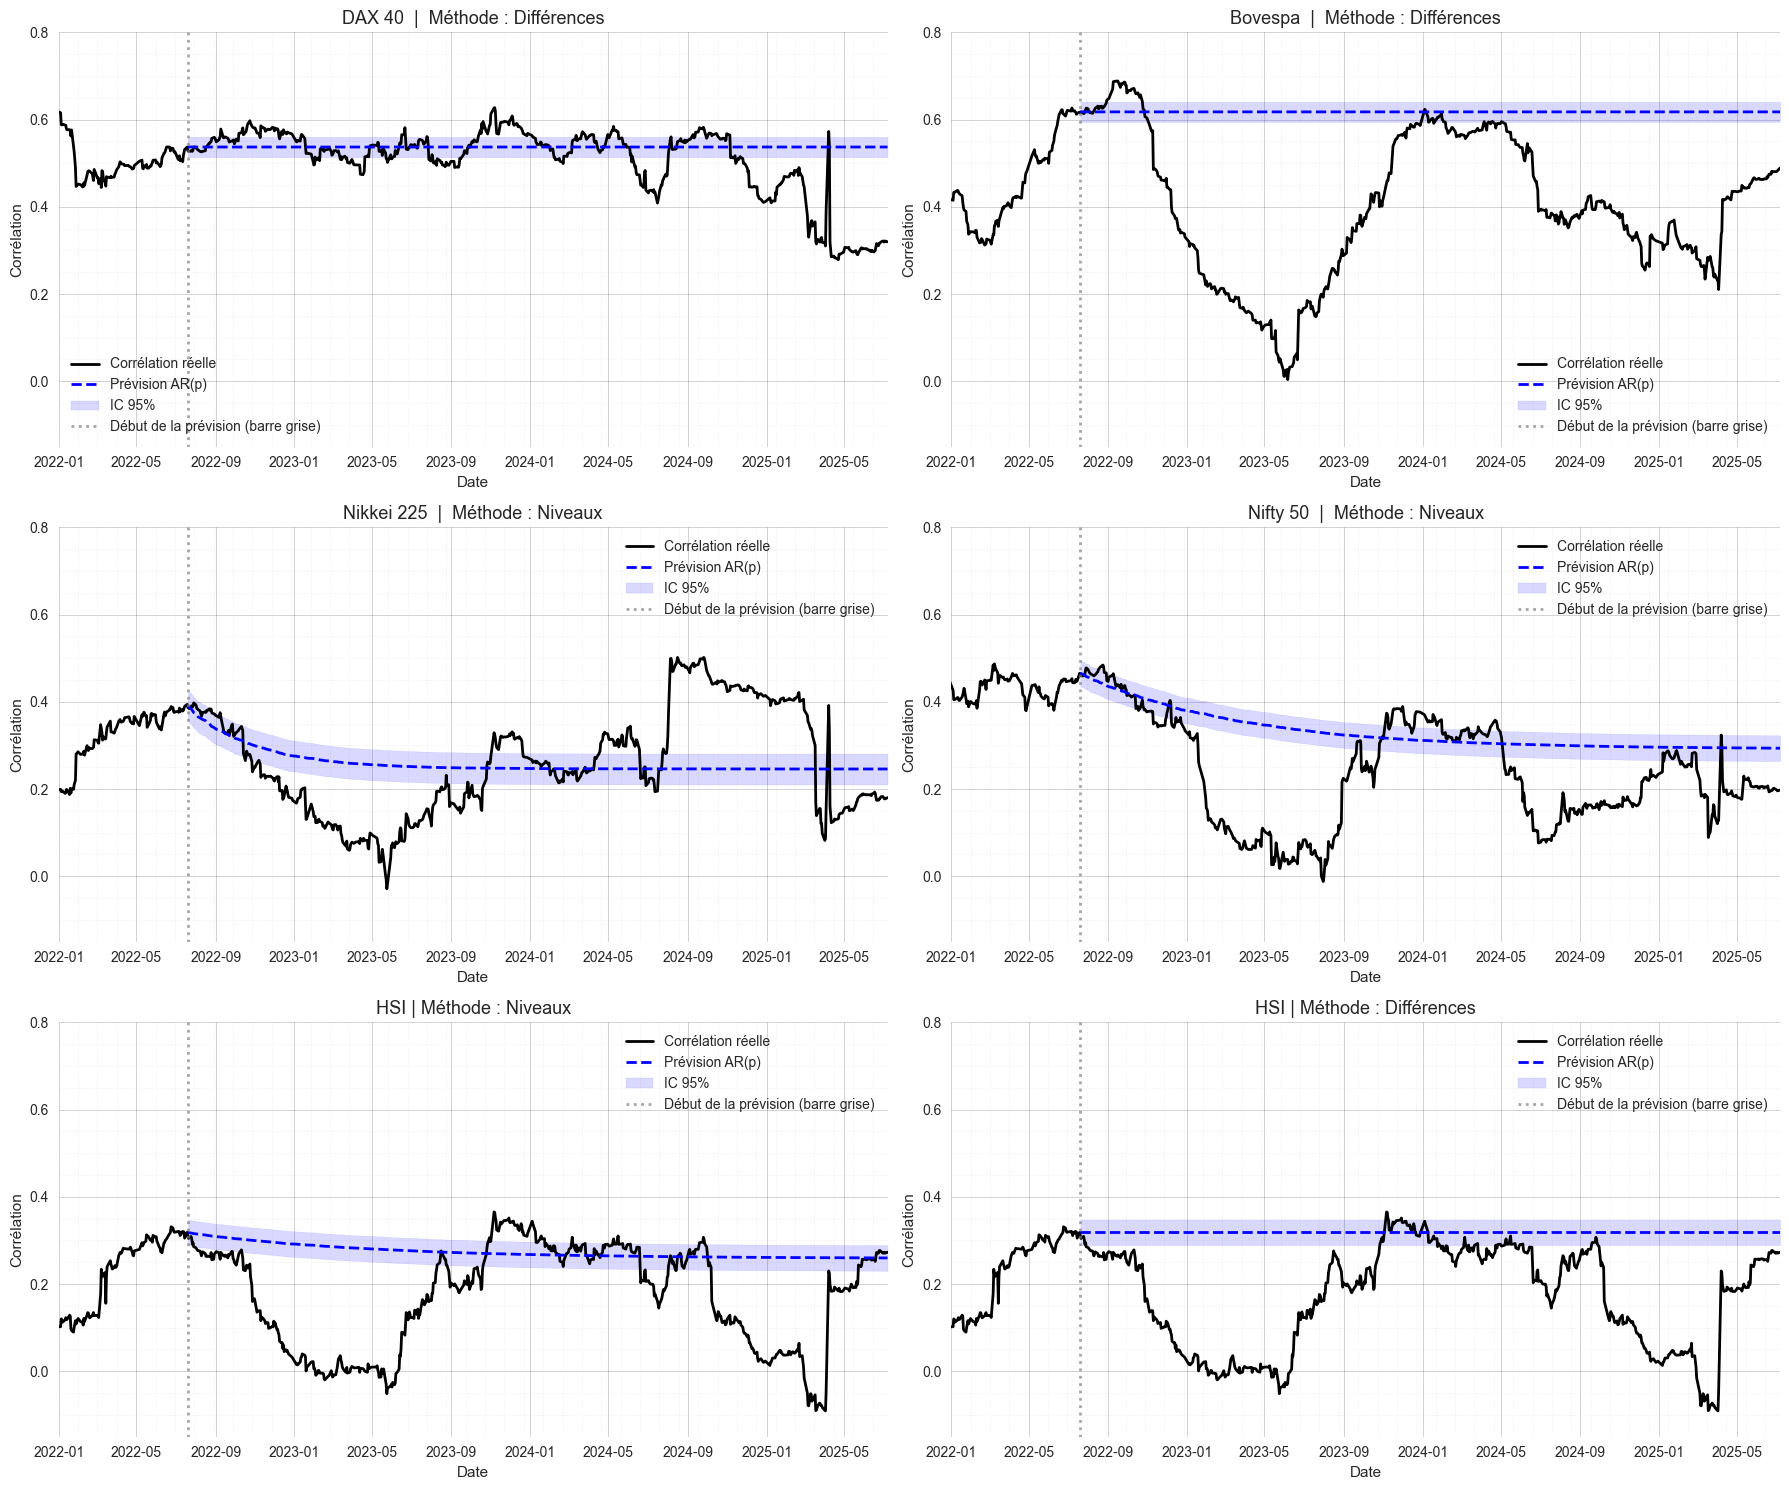

RMSE DAX 40: 0.0870
RMSE Bovespa: 0.2740
RMSE Nikkei 225: 0.1219
RMSE Nifty 50: 0.1483
RMSE HSI_niveau: 0.1583
RMSE HSI_diff: 0.1895


In [26]:
# Section 2.2 – Modélisation AR(p) avec IC
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error

# Ajouter deux colonnes pour HSI (niveau et différence)
correlations['Corr_HSI_niveau'] = correlations['Corr_HSI']
correlations['Corr_HSI_diff'] = correlations['Corr_HSI']

# On retire HSI de la liste principale et on ajoute ses deux variantes
specs = {
    'Corr_DAX 40': 'diff',
    'Corr_Bovespa': 'diff',
    'Corr_Nikkei 225': 'niveau',
    'Corr_Nifty 50': 'niveau',
    'Corr_HSI_niveau': 'niveau',
    'Corr_HSI_diff': 'diff'
}

results = []
predictions = {}

for col, spec in specs.items():
    y = correlations[col].dropna()
    split = int(len(y) * 0.8)
    train, test = y.iloc[:split], y.iloc[split:]

    # Sélection du p optimal via AIC
    best_aic = np.inf
    best_p = 1
    max_p = min(10, len(train)//10)
    for p in range(1, max_p+1):
        try:
            if spec == 'niveau':
                res = AutoReg(train, lags=p, trend='c', old_names=False).fit()
            else:
                y_diff = train.diff().dropna()
                res = AutoReg(y_diff, lags=p, trend='n', old_names=False).fit()
            if res.aic < best_aic:
                best_aic = res.aic
                best_p = p
        except Exception:
            continue

    # Modélisation finale avec p optimal
    if spec == 'niveau':
        res = AutoReg(train, lags=best_p, trend='c', old_names=False).fit()
        c = res.params[0]
        phi = res.params[1] if best_p == 1 else np.nan
        resid_std = np.std(res.resid)
        preds = []
        prev_vals = list(train.iloc[-best_p:])
        for t in range(len(test)):
            pred = c + sum(res.params[1:] * np.array(prev_vals[::-1]))
            preds.append(pred)
            prev_vals = prev_vals[1:] + [pred]
        preds = np.array(preds)
        ic_upper = preds + 1.96 * resid_std
        ic_lower = preds - 1.96 * resid_std
        rmse = np.sqrt(mean_squared_error(test, preds))
        lb_test = acorr_ljungbox(res.resid, lags=[10, 20], return_df=True)
        # Ajout erreurs-types
        se_c = res.bse[0]
        se_phi = res.bse[1] if best_p == 1 else np.nan
        results.append({
            'Marché': col.replace('Corr_', ''),
            'Spécification': 'Niveaux',
            'Constante': c,
            'StdErr_Constante': se_c,
            'Phi': phi,
            'StdErr_Phi': se_phi,
            'AIC': best_aic,
            'p_optimal': best_p,
            'RMSE': rmse,
            'LB_pval_10': lb_test['lb_pvalue'].iloc[0],
            'LB_pval_20': lb_test['lb_pvalue'].iloc[1]
        })
        predictions[col] = {'dates': test.index, 'y_true': test.values, 'y_pred': preds, 'ic_upper': ic_upper, 'ic_lower': ic_lower, 'spec': 'Niveaux', 'split_date': test.index[0], 'full_dates': y.index, 'full_values': y.values}
    else:
        y_diff = train.diff().dropna()
        res = AutoReg(y_diff, lags=best_p, trend='n', old_names=False).fit()
        phi = res.params[0] if best_p == 1 else np.nan
        resid_std = np.std(res.resid)
        last_level = train.iloc[-1]
        preds_level = [last_level]
        prev_diffs = list(y_diff.iloc[-best_p:])
        for t in range(len(test)):
            pred_diff = sum(res.params * np.array(prev_diffs[::-1]))
            pred_level = preds_level[-1] + pred_diff
            preds_level.append(pred_level)
            prev_diffs = prev_diffs[1:] + [pred_diff]
        preds_level = np.array(preds_level[1:])
        ic_upper = preds_level + 1.96 * resid_std
        ic_lower = preds_level - 1.96 * resid_std
        rmse = np.sqrt(mean_squared_error(test, preds_level))
        lb_test = acorr_ljungbox(res.resid, lags=[10, 20], return_df=True)
        # Ajout erreurs-types
        se_phi = res.bse[0] if best_p == 1 else np.nan
        results.append({
            'Marché': col.replace('Corr_', ''),
            'Spécification': 'Différences',
            'Phi': phi,
            'StdErr_Phi': se_phi,
            'AIC': best_aic,
            'p_optimal': best_p,
            'RMSE': rmse,
            'LB_pval_10': lb_test['lb_pvalue'].iloc[0],
            'LB_pval_20': lb_test['lb_pvalue'].iloc[1]
        })
        predictions[col] = {'dates': test.index, 'y_true': test.values, 'y_pred': preds_level, 'ic_upper': ic_upper, 'ic_lower': ic_lower, 'spec': 'Différences', 'split_date': test.index[0], 'full_dates': y.index, 'full_values': y.values}

# Tableau récapitulatif
results_df = pd.DataFrame(results)
print("\n TABLEAU AR(p) - RÉSULTATS DES MODÉLISATIONS")
print(results_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# 6 graphiques sur une seule image
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
axes = axes.flatten()
for i, col in enumerate(specs.keys()):
    pred = predictions[col]
    ax = axes[i]
    # Corrélation réelle sur toute la période
    ax.plot(pred['full_dates'], pred['full_values'], label='Corrélation réelle', color='black', linewidth=2)
    # Prévision AR(p) sur la période de test
    ax.plot(pred['dates'], pred['y_pred'], label='Prévision AR(p)', color='blue', linestyle='--', linewidth=2)
    ax.fill_between(pred['dates'], pred['ic_lower'], pred['ic_upper'], color='blue', alpha=0.15, label='IC 95%')
    # Ajout d'un titre explicite pour HSI
    if col == 'Corr_HSI_niveau':
        ax.set_title("HSI | Méthode : Niveaux", fontsize=13)
    elif col == 'Corr_HSI_diff':
        ax.set_title("HSI | Méthode : Différences", fontsize=13)
    else:
        ax.set_title(f"{col.replace('Corr_', '')}  |  Méthode : {pred['spec']}", fontsize=13)
    ax.set_xlabel('Date')
    ax.set_ylabel('Corrélation')
    # Ligne verticale grise pointillée + annotation au début de la prévision
    split_date = pred['split_date']
    vline = ax.axvline(split_date, color='gray', linestyle=':', linewidth=2, alpha=0.7)
    # Limite de l'axe x à partir de 2022
    ax.set_xlim(pd.Timestamp('2022-01-01'), pred['full_dates'][-1])
    # Légende personnalisée
    handles, labels = ax.get_legend_handles_labels()
    handles.append(vline)
    labels.append('Début de la prévision (barre grise)')
    if col == 'Corr_DAX 40':
        ax.legend(handles, labels, loc='lower left')
    else:
        ax.legend(handles, labels)
    ax.grid(True, which='major', axis='both', color='gray', linestyle='-', linewidth=0.7, alpha=0.35)
    ax.minorticks_on()
    ax.grid(True, which='minor', axis='both', color='gray', linestyle=':', linewidth=0.5, alpha=0.18)
    ax.set_facecolor('white')
    ax.set_ylim(-0.15, 0.8)  # Limite d'axe y demandée
plt.tight_layout()
plt.show()

# Affichage RMSE pour chaque marché
for col in specs.keys():
    print(f"RMSE {col.replace('Corr_', '')}: {results_df.loc[results_df['Marché'] == col.replace('Corr_', ''), 'RMSE'].values[0]:.4f}")


In [27]:
# 2.3 - Préparation des données explicatives pour chaque marché (fusion VIX + alignement régression)
print("Téléchargement et préparation des données VIX pour la régression explicative...")

# Télécharger les données VIX
vix_data = yf.download('^VIX', start=start_date, end=end_date, progress=False)

# Vérifier que 'correlations' existe, sinon le créer
if 'correlations' not in locals():
    correlations = pd.DataFrame()

if not vix_data.empty:
    # Si correlations est vide, utiliser l'index de vix_data
    if correlations.empty:
        correlations = pd.DataFrame(index=vix_data.index)
    # Aligner les données VIX avec les corrélations
    vix_aligned = vix_data['Close'].reindex(correlations.index, method='ffill')
    
    # Calculer log(VIX) comme spécifié dans l'énoncé
    log_vix = np.log(vix_aligned)
    
    print(f"✓ Données VIX récupérées : {len(vix_aligned)} observations")
    print(f"Période VIX alignée : {vix_aligned.index[0].strftime('%Y-%m-%d')} à {vix_aligned.index[-1].strftime('%Y-%m-%d')}")
    
    # Statistiques descriptives du VIX et log(VIX)
    print(f"\nStatistiques descriptives du VIX :")
    print(f"VIX - Moyenne: {float(vix_aligned.mean()):.2f}, Écart-type: {float(vix_aligned.std()):.2f}")
    print(f"VIX - Min: {float(vix_aligned.min()):.2f}, Max: {float(vix_aligned.max()):.2f}")
    
    print(f"\nStatistiques descriptives de log(VIX) :")
    print(f"log(VIX) - Moyenne: {float(log_vix.mean()):.4f}, Écart-type: {float(log_vix.std()):.4f}")
    print(f"log(VIX) - Min: {float(log_vix.min()):.4f}, Max: {float(log_vix.max()):.4f}")
    
    # Sauvegarder pour les étapes suivantes
    correlations['VIX'] = vix_aligned
    correlations['log_VIX'] = log_vix
    
    print(f"\n✓ Variables ajoutées au DataFrame des corrélations")
    print(f"Shape final du DataFrame : {correlations.shape}")
    
    # Vérifier la cohérence des données
    print(f"\nVérification des données finales :")
    print(f"Valeurs manquantes :")
    print(correlations[['VIX', 'log_VIX']].isnull().sum())

    # Préparation des données pour la régression explicative (Corr vs log(VIX))
    print("\nPréparation des données pour la régression explicative (Corr vs log(VIX))...")
    markets = [col for col in correlations.columns if col.startswith('Corr_')]
    regression_data = {}
    if 'log_VIX' in correlations.columns:
        for market in markets:
            # Extraire la série de corrélation et log(VIX), aligner et retirer les valeurs nulles
            df = pd.DataFrame({
                'Corr': correlations[market],
                'log_VIX': correlations['log_VIX']
            }).dropna()
            regression_data[market] = df
            print(f"{market}: {len(df)} observations alignées, période {df.index[0].strftime('%Y-%m-%d')} à {df.index[-1].strftime('%Y-%m-%d')}")

        # Vérification rapide
        for market, df in regression_data.items():
            print(f"\n{market} - Aperçu des données alignées :")
            print(df.head())
    else:
        print("✗ La colonne 'log_VIX' est absente du DataFrame correlations. Impossible de préparer les données explicatives pour la régression.")
else:
    print("✗ Erreur lors du téléchargement des données VIX")

Téléchargement et préparation des données VIX pour la régression explicative...
✓ Données VIX récupérées : 3062 observations
Période VIX alignée : 2010-08-09 à 2025-07-07

Statistiques descriptives du VIX :
VIX - Moyenne: 18.21, Écart-type: 6.93
VIX - Min: 9.22, Max: 82.69

Statistiques descriptives de log(VIX) :
log(VIX) - Moyenne: 2.8468, Écart-type: 0.3177
log(VIX) - Min: 2.2214, Max: 4.4151

✓ Variables ajoutées au DataFrame des corrélations
Shape final du DataFrame : (3062, 9)

Vérification des données finales :
Valeurs manquantes :
VIX        0
log_VIX    0
dtype: int64

Préparation des données pour la régression explicative (Corr vs log(VIX))...
Corr_DAX 40: 3062 observations alignées, période 2010-08-09 à 2025-07-07
Corr_Nikkei 225: 3062 observations alignées, période 2010-08-09 à 2025-07-07
Corr_Bovespa: 3062 observations alignées, période 2010-08-09 à 2025-07-07
Corr_Nifty 50: 3062 observations alignées, période 2010-08-09 à 2025-07-07
Corr_HSI: 3062 observations alignées, pé

In [28]:
# 2.3 - Estimation des modèles linéaire et quadratique pour chaque marché
import statsmodels.api as sm
import pandas as pd

print("\n ESTIMATION DES MODÈLES DE RÉGRESSION : Corr ~ log(VIX) et Corr ~ log(VIX) + (log(VIX))^2")
print("="*80)

results_summary = []

for market, df in regression_data.items():
    # Modèle linéaire
    X_lin = sm.add_constant(df['log_VIX'])
    model_lin = sm.OLS(df['Corr'], X_lin).fit()

    # Modèle quadratique
    X_quad = pd.DataFrame({
        'const': 1,
        'log_VIX': df['log_VIX'],
        'log_VIX_sq': df['log_VIX']**2
    })
    model_quad = sm.OLS(df['Corr'], X_quad).fit()

    # Stocker les résultats
    results_summary.append({
        'Marché': market.replace('Corr_', ''),
        'Modèle': 'Linéaire',
        'N obs.': int(model_lin.nobs),
        'R²': f"{model_lin.rsquared:.4f}",
        'β0': f"{model_lin.params['const']:.4f}",
        'β1': f"{model_lin.params['log_VIX']:.4f}",
        'StdErr_β0': f"{model_lin.bse['const']:.4f}",
        'StdErr_β1': f"{model_lin.bse['log_VIX']:.4f}",
        'β2': '',
        'StdErr_β2': ''
    })

    results_summary.append({
        'Marché': market.replace('Corr_', ''),
        'Modèle': 'Quadratique',
        'N obs.': int(model_quad.nobs),
        'R²': f"{model_quad.rsquared:.4f}",
        'β0': f"{model_quad.params['const']:.4f}",
        'β1': f"{model_quad.params['log_VIX']:.4f}",
        'StdErr_β0': f"{model_quad.bse['const']:.4f}",
        'StdErr_β1': f"{model_quad.bse['log_VIX']:.4f}",
        'β2': f"{model_quad.params['log_VIX_sq']:.4f}",
        'StdErr_β2': f"{model_quad.bse['log_VIX_sq']:.4f}"
    })

# Tableau professionnel
cols_order = ['Marché', 'Modèle', 'N obs.', 'R²', 'β0', 'StdErr_β0', 'β1', 'StdErr_β1', 'β2', 'StdErr_β2']
df_results = pd.DataFrame(results_summary)
df_results = df_results[cols_order]

print("\n📊 TABLEAU 2.3.1 : Estimation des modèles linéaire et quadratique")
print("(Coefficients, erreurs-types, R², N obs. pour chaque marché)")
print("="*120)
print(df_results.to_string(index=False))
print("="*120)




 ESTIMATION DES MODÈLES DE RÉGRESSION : Corr ~ log(VIX) et Corr ~ log(VIX) + (log(VIX))^2

📊 TABLEAU 2.3.1 : Estimation des modèles linéaire et quadratique
(Coefficients, erreurs-types, R², N obs. pour chaque marché)
    Marché      Modèle  N obs.     R²      β0 StdErr_β0      β1 StdErr_β1      β2 StdErr_β2
    DAX 40    Linéaire    3062 0.0468  0.3492    0.0187  0.0799    0.0065                  
    DAX 40 Quadratique    3062 0.0576  1.0344    0.1175 -0.3865    0.0792  0.0783    0.0133
Nikkei 225    Linéaire    3062 0.0315  0.0815    0.0166  0.0577    0.0058                  
Nikkei 225 Quadratique    3062 0.0317  0.1631    0.1048  0.0021    0.0707  0.0093    0.0118
   Bovespa    Linéaire    3062 0.2149 -0.2920    0.0275  0.2776    0.0096                  
   Bovespa Quadratique    3062 0.2150 -0.4059    0.1740  0.3551    0.1174 -0.0130    0.0196
  Nifty 50    Linéaire    3062 0.1700 -0.2242    0.0201  0.1753    0.0070                  
  Nifty 50 Quadratique    3062 0.1702 -0.1112 

In [29]:
# 2.3 - Détection de la relation en U et calcul du point de bascule du VIX
import numpy as np

u_markets = []
for market, df in regression_data.items():
    # Modèle quadratique
    X_quad = pd.DataFrame({
        'const': 1,
        'log_VIX': df['log_VIX'],
        'log_VIX_sq': df['log_VIX']**2
    })
    model_quad = sm.OLS(df['Corr'], X_quad).fit()
    b1 = model_quad.params['log_VIX']
    b2 = model_quad.params['log_VIX_sq']
    # Vérifier la relation en U
    if (b1 < 0) and (b2 > 0):
        # Calcul du point de bascule (minimum de la parabole)
        log_vix_star = -b1/(2*b2)
        vix_star = np.exp(log_vix_star)
        u_markets.append({
            'Marché': market.replace('Corr_', ''),
            'β1': b1,
            'β2': b2,
            'log(VIX)_star': log_vix_star,
            'VIX_star': vix_star
        })

if u_markets:
    print("\n📍 Marchés avec relation en U détectée (β1 < 0 et β2 > 0) :")
    for res in u_markets:
        print(f"- {res['Marché']}: β1 = {res['β1']:.4f}, β2 = {res['β2']:.4f}")
        print(f"  → Point de bascule log(VIX)* = {res['log(VIX)_star']:.4f}, VIX* = {res['VIX_star']:.2f}")



📍 Marchés avec relation en U détectée (β1 < 0 et β2 > 0) :
- DAX 40: β1 = -0.3865, β2 = 0.0783
  → Point de bascule log(VIX)* = 2.4676, VIX* = 11.79


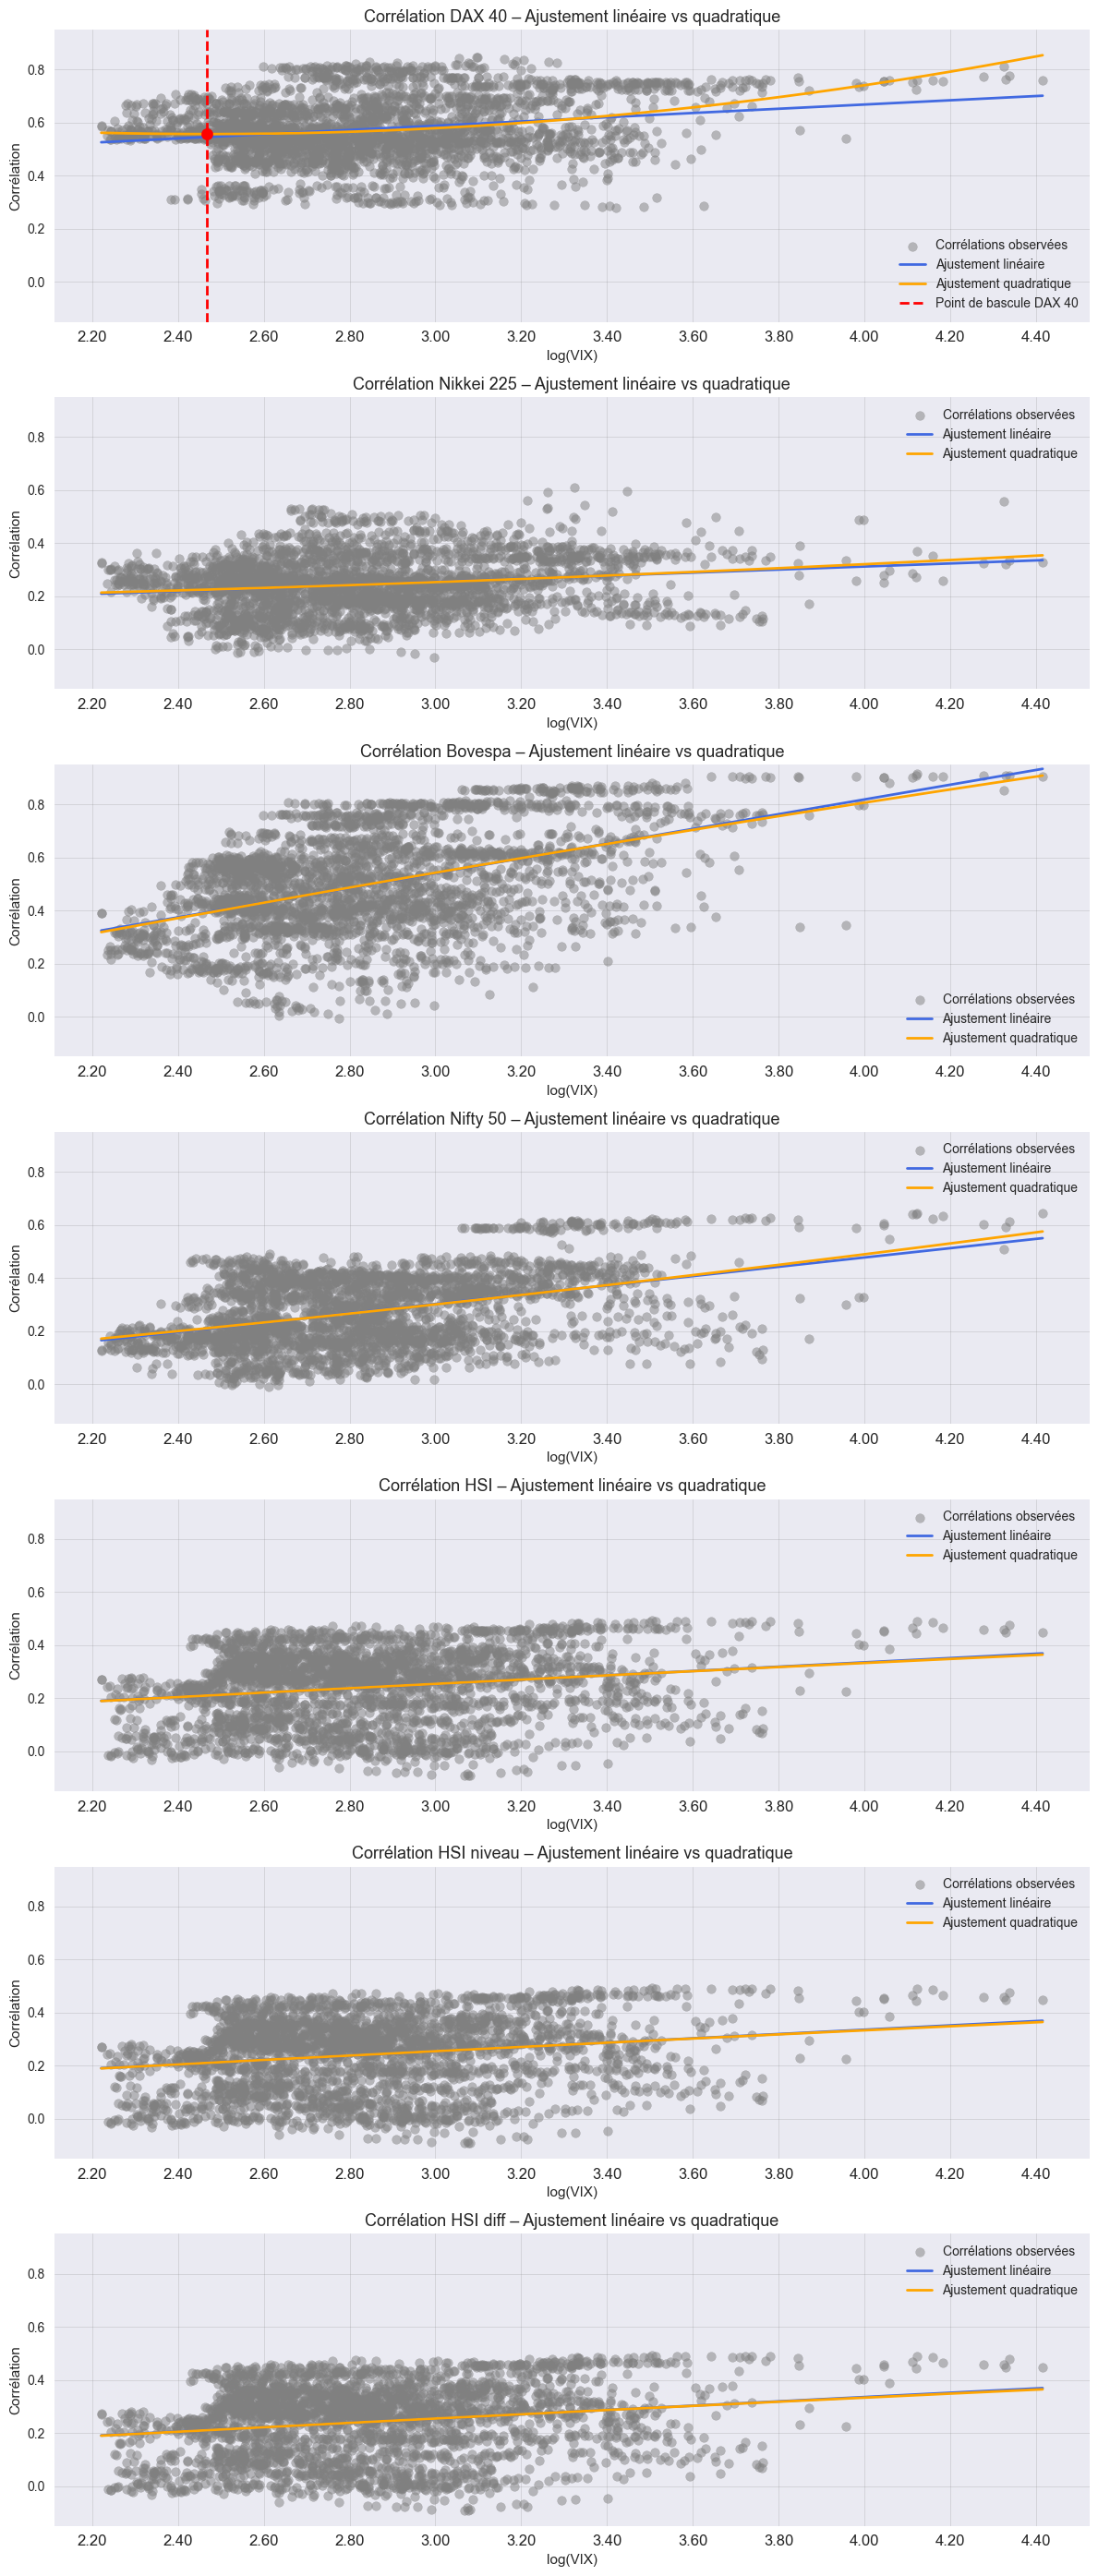

In [30]:
# 2.3 - Visualisation nuage de points + ajustements linéaire/quadratique + point de bascule DAX 40
import matplotlib.pyplot as plt
import numpy as np

n_markets = len(regression_data)
fig, axes = plt.subplots(n_markets, 1, figsize=(12, 4 * n_markets), sharex=False)
if n_markets == 1:
    axes = [axes]

# Définir des ticks réguliers pour l'axe des x 
global_min = min([df['log_VIX'].min() for df in regression_data.values()])
global_max = max([df['log_VIX'].max() for df in regression_data.values()])
tick_start = np.floor(global_min * 10) / 10
tick_end = np.ceil(global_max * 10) / 10
ticks = np.arange(tick_start, tick_end + 0.01, 0.20)

# Récupérer le point de bascule pour DAX 40 
dax_bascule = None
for market, df in regression_data.items():
    if 'DAX 40' in market:
        X_quad = pd.DataFrame({
            'const': 1,
            'log_VIX': df['log_VIX'],
            'log_VIX_sq': df['log_VIX']**2
        })
        model_quad = sm.OLS(df['Corr'], X_quad).fit()
        b1 = model_quad.params['log_VIX']
        b2 = model_quad.params['log_VIX_sq']
        if (b1 < 0) and (b2 > 0):
            dax_bascule = -b1/(2*b2)
        break

for i, (market, df) in enumerate(regression_data.items()):
    
    market_clean = market.replace('Corr_', '').replace('_', ' ').replace('DAX 40', 'DAX 40')
    # Modèle linéaire
    X_lin = sm.add_constant(df['log_VIX'])
    model_lin = sm.OLS(df['Corr'], X_lin).fit()
    # Modèle quadratique
    X_quad = pd.DataFrame({
        'const': 1,
        'log_VIX': df['log_VIX'],
        'log_VIX_sq': df['log_VIX']**2
    })
    model_quad = sm.OLS(df['Corr'], X_quad).fit()
    # Nuage de points
    ax = axes[i]
    ax.scatter(df['log_VIX'], df['Corr'], color='gray', alpha=0.5, label='Corrélations observées')
    # Ligne d'ajustement linéaire
    x_vals = np.linspace(df['log_VIX'].min(), df['log_VIX'].max(), 200)
    y_lin = model_lin.params['const'] + model_lin.params['log_VIX'] * x_vals
    ax.plot(x_vals, y_lin, color='royalblue', label='Ajustement linéaire', linewidth=2)
    # Ligne d'ajustement quadratique
    y_quad = model_quad.params['const'] + model_quad.params['log_VIX'] * x_vals + model_quad.params['log_VIX_sq'] * x_vals**2
    ax.plot(x_vals, y_quad, color='orange', label='Ajustement quadratique', linewidth=2)
    ax.set_title(f"Corrélation {market_clean} – Ajustement linéaire vs quadratique", fontsize=13)
    ax.set_xlabel('log(VIX)')
    ax.set_ylabel('Corrélation')
    ax.set_ylim(-0.15, 0.95)
    # Appliquer les ticks réguliers à tous les graphiques
    ax.set_xticks(ticks)
    ax.set_xticklabels([f'{tick:.2f}' for tick in ticks], fontsize=12)
    # Ajouter le point de bascule en rouge pour DAX 40
    if 'DAX 40' in market and dax_bascule is not None:
        ax.axvline(dax_bascule, color='red', linestyle='--', linewidth=2, label='Point de bascule DAX 40')
        ax.scatter([dax_bascule], [model_quad.params['const'] + model_quad.params['log_VIX'] * dax_bascule + model_quad.params['log_VIX_sq'] * dax_bascule**2], color='red', s=80, zorder=5)
    ax.legend()
    ax.grid(True, which='major', axis='both', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
plt.tight_layout()
plt.show()


 TABLEAU 2.4 : Comparatif RMSE – AR(p) vs ARX quadratique
    Marché  RMSE – AR  RMSE – ARX  Gain (%) Meilleur modèle
    DAX 40     0.0870      0.0966  -10.9522           AR(p)
   Bovespa     0.2740      0.2746   -0.2054           AR(p)
Nikkei 225     0.1219      0.1301   -6.7873           AR(p)
  Nifty 50     0.1483      0.1421    4.1410 ARX quadratique
       HSI     0.1583      0.1703   -7.5807           AR(p)

 COEFFICIENTS DU MODÈLE ARX QUADRATIQUE
    Marché  Constante  Corrₜ₋₁  log(VIXₜ₋₁)  [log(VIXₜ₋₁)]²  R² ajusté   RMSE
    DAX 40    -0.0170  -0.0107       0.0122         -0.0022     0.0003 0.0966
   Bovespa     0.0088   0.0234      -0.0077          0.0016     0.0092 0.2746
Nikkei 225    -0.0429   0.9829       0.0315         -0.0052     0.9660 0.1301
  Nifty 50     0.0231   0.9803      -0.0169          0.0034     0.9878 0.1421
       HSI    -0.0171   0.9931       0.0123         -0.0020     0.9876 0.1703


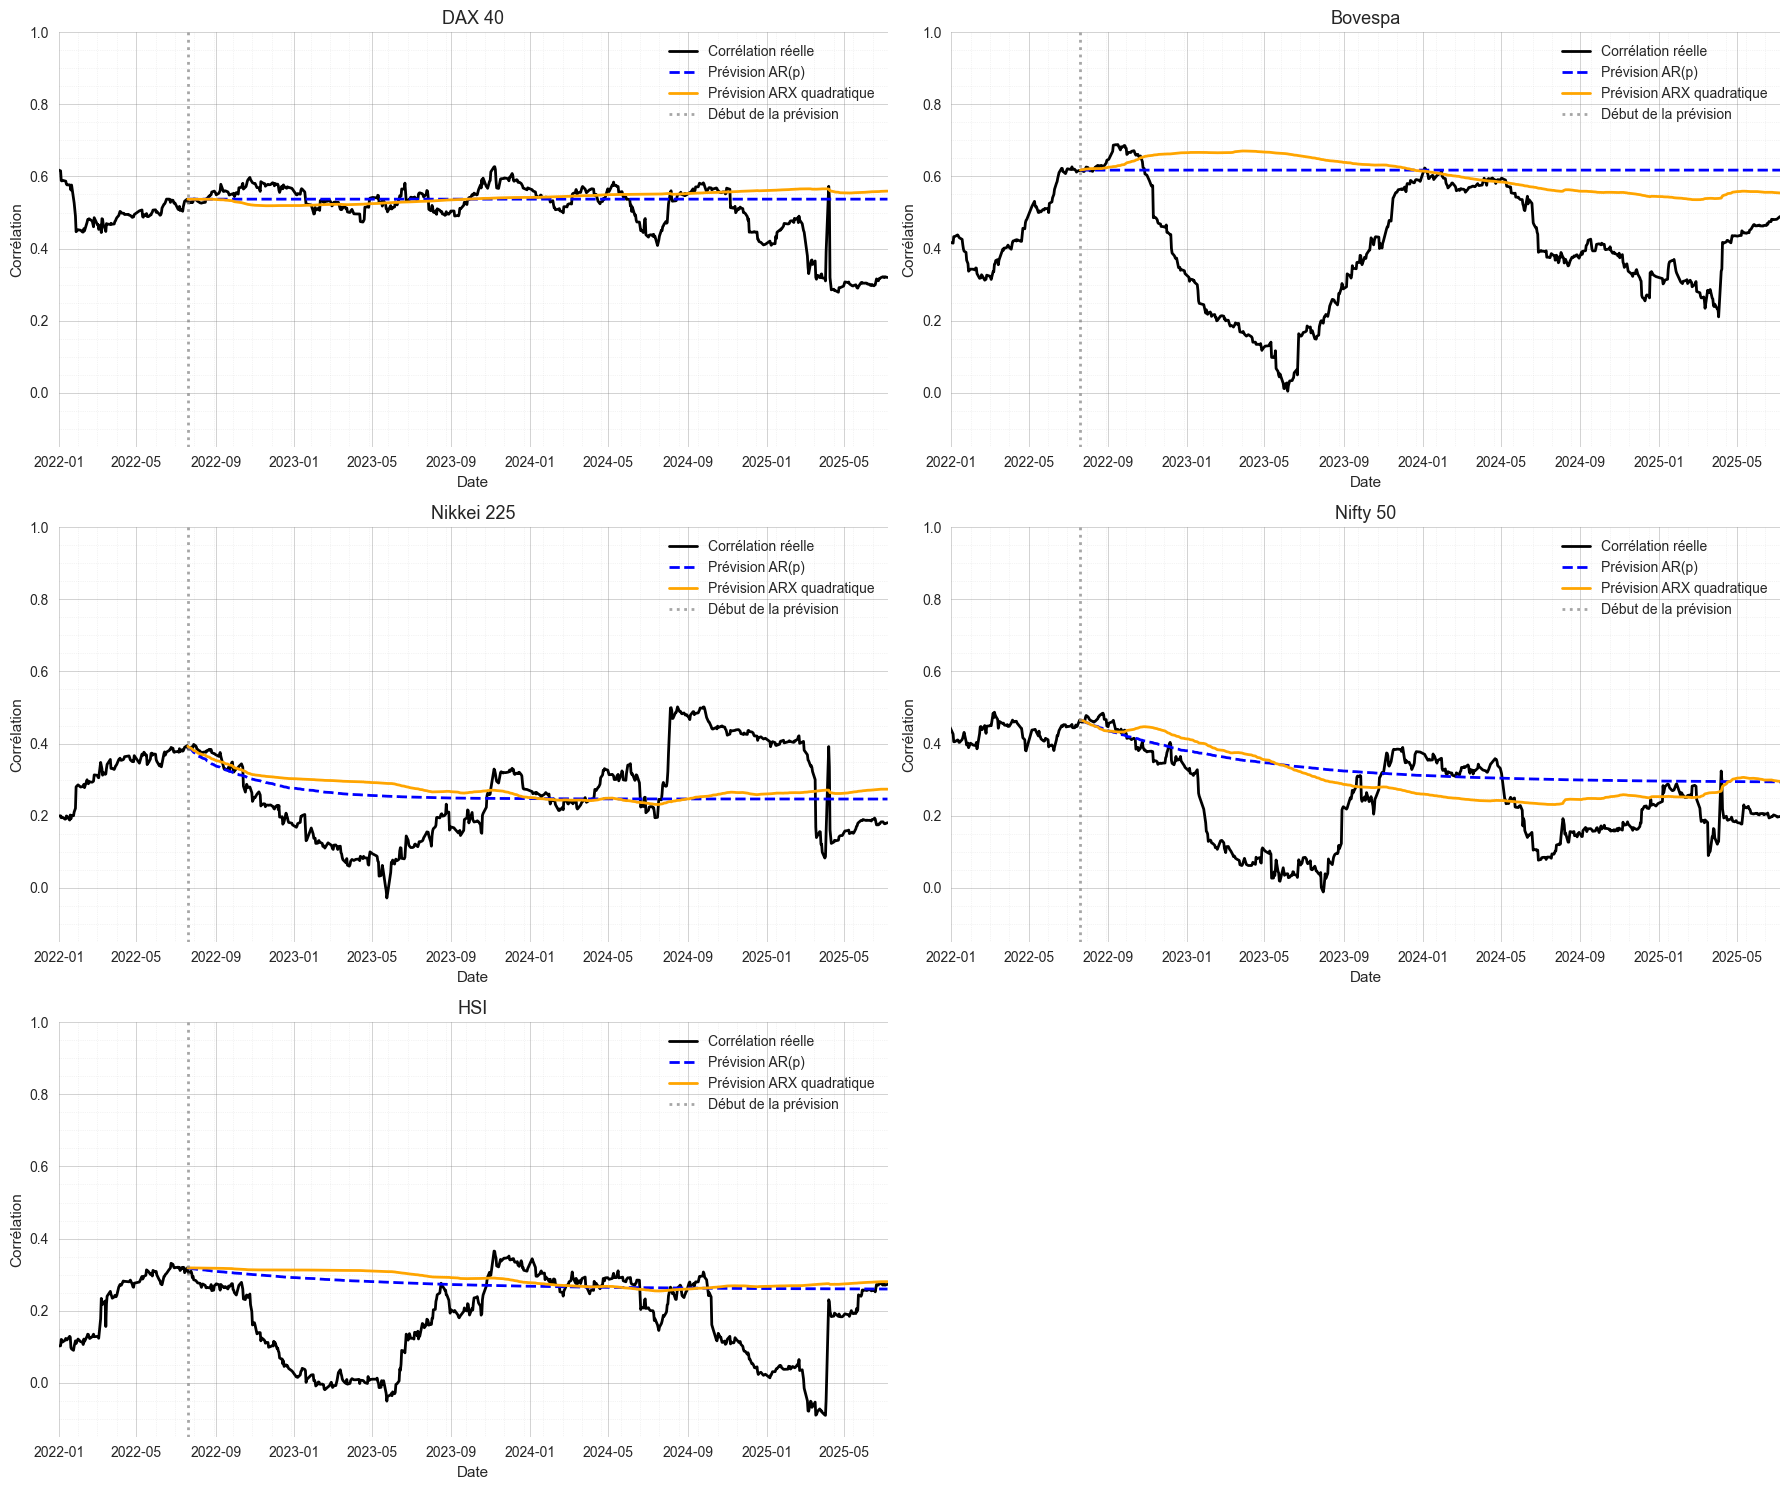

In [31]:
# 2.4 – Protocole strict ARX (AR(p) et ARX quadratique uniquement, fit unique sur train, buffers indépendants, bornage, visuel conforme)
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings("ignore", category=ValueWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

specs = {
    'Corr_DAX 40': 'diff',
    'Corr_Bovespa': 'diff',
    'Corr_Nikkei 225': 'niveau',
    'Corr_Nifty 50': 'niveau',
    'Corr_HSI': 'niveau'
}

results = []
results_coef = []
predictions = {}

for col, spec in specs.items():
    y = correlations[col].dropna()
    log_vix = correlations['log_VIX'].reindex(y.index)
    log_vix_sq = log_vix ** 2
    split = int(len(y) * 0.8)
    train, test = y.iloc[:split], y.iloc[split:]
    log_vix_train = log_vix.iloc[:split]
    log_vix_test = log_vix.iloc[split:]
    log_vix_sq_train = log_vix_sq.iloc[:split]
    log_vix_sq_test = log_vix_sq.iloc[split:]

    # Sélection du p optimal via AIC (comme en 2.2)
    best_aic = np.inf
    best_p = 1
    max_p = min(10, len(train)//10)
    for p in range(1, max_p+1):
        try:
            if spec == 'niveau':
                res = AutoReg(train, lags=p, trend='c', old_names=False).fit()
            else:
                y_diff = train.diff().dropna()
                res = AutoReg(y_diff, lags=p, trend='n', old_names=False).fit()
            if res.aic < best_aic:
                best_aic = res.aic
                best_p = p
        except Exception:
            continue

    # --- AR(p) je devrais trouver même chose qu'au 2.2 ---
    if spec == 'niveau':
        res = AutoReg(train, lags=best_p, trend='c', old_names=False).fit()
        c = res.params[0]
        resid_std = np.std(res.resid)
        preds_ar = []
        prev_vals = list(train.iloc[-best_p:])
        for t in range(len(test)):
            pred = c + sum(res.params[1:] * np.array(prev_vals[::-1]))
            preds_ar.append(pred)
            prev_vals = prev_vals[1:] + [pred]
        preds_ar = np.array(preds_ar)
        rmse_ar = np.sqrt(mean_squared_error(test, np.clip(preds_ar, -1, 1)))
    else:
        y_diff = train.diff().dropna()
        res = AutoReg(y_diff, lags=best_p, trend='n', old_names=False).fit()
        resid_std = np.std(res.resid)
        last_level = train.iloc[-1]
        preds_level = [last_level]
        prev_diffs = list(y_diff.iloc[-best_p:])
        for t in range(len(test)):
            pred_diff = sum(res.params * np.array(prev_diffs[::-1]))
            pred_level = preds_level[-1] + pred_diff
            preds_level.append(pred_level)
            prev_diffs = prev_diffs[1:] + [pred_diff]
        preds_ar = np.array(preds_level[1:])
        rmse_ar = np.sqrt(mean_squared_error(test, np.clip(preds_ar, -1, 1)))

    # --- ARX quadratique ---
    def make_X(y_series, log_vix_series, log_vix_sq_series, p):
        X = pd.DataFrame({f'y_lag{i+1}': y_series.shift(i+1) for i in range(p)})
        X['log_vix_lag1'] = log_vix_series.shift(1)
        X['log_vix_sq_lag1'] = log_vix_sq_series.shift(1)
        return X
    if spec == 'niveau':
        X_train = make_X(train, log_vix_train, log_vix_sq_train, best_p).dropna()
        y_train_fit = train.loc[X_train.index]
        X_test = make_X(pd.concat([train, test]), pd.concat([log_vix_train, log_vix_test]), pd.concat([log_vix_sq_train, log_vix_sq_test]), best_p).iloc[split:].copy()
        model_quad = OLS(y_train_fit, add_constant(X_train, has_constant='add')).fit(cov_type='HC3')
        preds_arx_quad = []
        buffer_quad = list(train.iloc[-best_p:])
        for t in range(len(test)):
            x_row = pd.DataFrame({
                **{f'y_lag{i+1}': buffer_quad[-(i+1)] for i in range(best_p)},
                'log_vix_lag1': log_vix_test.iloc[t-1] if t > 0 else log_vix_train.iloc[-1],
                'log_vix_sq_lag1': log_vix_sq_test.iloc[t-1] if t > 0 else log_vix_sq_train.iloc[-1]
            }, index=[0])
            x_row = add_constant(x_row, has_constant='add')
            pred = model_quad.predict(x_row).item()
            preds_arx_quad.append(pred)
            buffer_quad = buffer_quad[1:] + [pred]
    else:
        train_diff = train.diff().dropna()
        X_train = make_X(train_diff, log_vix_train, log_vix_sq_train, best_p).dropna()
        y_train_fit = train_diff.loc[X_train.index]
        X_test = make_X(pd.concat([train, test]).diff().dropna(), pd.concat([log_vix_train, log_vix_test]), pd.concat([log_vix_sq_train, log_vix_sq_test]), best_p).iloc[split:].copy()
        model_quad = OLS(y_train_fit, add_constant(X_train, has_constant='add')).fit(cov_type='HC3')
        preds_arx_quad = []
        buffer_quad = list(train_diff.iloc[-best_p:])
        last_level_quad = train.iloc[-1]
        for t in range(len(test)):
            x_row = pd.DataFrame({
                **{f'y_lag{i+1}': buffer_quad[-(i+1)] for i in range(best_p)},
                'log_vix_lag1': log_vix_test.iloc[t-1] if t > 0 else log_vix_train.iloc[-1],
                'log_vix_sq_lag1': log_vix_sq_test.iloc[t-1] if t > 0 else log_vix_sq_train.iloc[-1]
            }, index=[0])
            x_row = add_constant(x_row, has_constant='add')
            pred_diff = model_quad.predict(x_row).item()
            pred_level = last_level_quad + pred_diff
            preds_arx_quad.append(pred_level)
            last_level_quad = pred_level
            buffer_quad = buffer_quad[1:] + [pred_diff]
    preds_arx_quad = np.clip(np.array(preds_arx_quad), -1, 1)
    rmse_arx_quad = np.sqrt(mean_squared_error(test, preds_arx_quad))

    # Récupérer les coefficients pour le tableau demandé
    coef = model_quad.params
    r2_adj = model_quad.rsquared_adj
    results_coef.append({
        'Marché': col.replace('Corr_', ''),
        'Constante': coef.get('const', np.nan),
        'Corrₜ₋₁': coef.get('y_lag1', np.nan),
        'log(VIXₜ₋₁)': coef.get('log_vix_lag1', np.nan),
        '[log(VIXₜ₋₁)]²': coef.get('log_vix_sq_lag1', np.nan),
        'R² ajusté': r2_adj,
        'RMSE': rmse_arx_quad
    })

    gain_quad_vs_ar = 100 * (rmse_ar - rmse_arx_quad) / rmse_ar if rmse_ar != 0 else np.nan
    meilleur_modele = 'ARX quadratique' if rmse_arx_quad < rmse_ar else 'AR(p)'

    results.append({
        'Marché': col.replace('Corr_', ''),
        'RMSE – AR': rmse_ar,
        'RMSE – ARX': rmse_arx_quad,
        'Gain (%)': gain_quad_vs_ar,
        'Meilleur modèle': meilleur_modele
    })
    predictions[col] = {
        'dates': test.index,
        'y_true': test.values,
        'y_pred_ar': np.clip(preds_ar, -1, 1),
        'y_pred_quad': preds_arx_quad,
        'full_dates': y.index,
        'full_values': y.values,
        'split_date': test.index[0]
    }

# Nouveau tableau comparatif demandé
results_df = pd.DataFrame(results)
print("\n TABLEAU 2.4 : Comparatif RMSE – AR(p) vs ARX quadratique")
print(results_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Nouveau tableau des coefficients du modèle ARX quadratique
coef_df = pd.DataFrame(results_coef)
print("\n COEFFICIENTS DU MODÈLE ARX QUADRATIQUE")
print(coef_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# 5 graphiques sur une seule image (affichage 3 lignes x 2 colonnes, dernier graphique masqué)
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
axes = axes.flatten()
for i, col in enumerate(specs.keys()):
    pred = predictions[col]
    ax = axes[i]
    # Corrélation réelle sur toute la période
    ax.plot(pred['full_dates'], pred['full_values'], label='Corrélation réelle', color='black', linewidth=2)
    # Prévisions sur la période de test
    ax.plot(pred['dates'], pred['y_pred_ar'], label='Prévision AR(p)', color='blue', linestyle='--', linewidth=2)
    ax.plot(pred['dates'], pred['y_pred_quad'], label='Prévision ARX quadratique', color='orange', linestyle='-', linewidth=2)
    # Ligne verticale au début de la prévision
    split_date = pred['split_date']
    vline = ax.axvline(split_date, color='gray', linestyle=':', linewidth=2, alpha=0.7)
    handles, labels = ax.get_legend_handles_labels()
    handles.append(vline)
    labels.append('Début de la prévision')
    ax.legend(handles, labels)
    ax.set_title(f"{col.replace('Corr_', '')}", fontsize=13)
    ax.set_xlabel('Date')
    ax.set_ylabel('Corrélation')
    ax.grid(True, which='major', axis='both', color='gray', linestyle='-', linewidth=0.7, alpha=0.35)
    ax.minorticks_on()
    ax.grid(True, which='minor', axis='both', color='gray', linestyle=':', linewidth=0.5, alpha=0.18)
    ax.set_facecolor('white')
    ax.set_ylim(-0.15, 1.0)
    ax.set_xlim(pd.Timestamp('2022-01-01'), pred['full_dates'][-1])
# Masquer le dernier graphique vide si specs < 6
for j in range(len(specs), len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()